In [44]:
import matplotlib.pyplot as plt
import google.datalab.bigquery as bq

query1="""
SELECT
  class.code encounter_class, period.end end_timestamp, period.start start_timestamp,
  TIMESTAMP_DIFF(TIMESTAMP(period.end), TIMESTAMP(period.start), HOUR) as length_of_stay_in_hours
FROM
  synthea.Encounter
WHERE
  period.end >= period.start
ORDER BY
  4 DESC
LIMIT 10
"""

df1 = bq.Query(query1).execute().result().to_dataframe()
df1.head()

,encounter_class,end_timestamp,start_timestamp,length_of_stay_in_hours
0,emergency,2017-06-28T15:55:28+00:00,1994-09-07T15:55:28+00:00,199920
1,emergency,2017-06-28T15:55:28+00:00,1994-09-07T15:55:28+00:00,199920
2,emergency,2017-06-28T15:55:28+00:00,1994-09-07T15:55:28+00:00,199920
3,ambulatory,2011-10-30T15:48:27+00:00,1999-06-27T15:48:27+00:00,108192
4,ambulatory,1992-06-22T22:33:27+00:00,1980-12-19T22:33:27+00:00,100872


In [13]:
query2="""
SELECT
  cc.code loinc_code,
  cc.display loinc_name,
  approx_quantiles(round(o.value.quantity.value,1),4) as quantiles,
  count(*) as num_obs
FROM
  synthea.Observation o, o.code.coding cc
WHERE
  cc.system like '%loinc%' and lower(cc.display) like '%cholesterol%'
GROUP BY 1,2
ORDER BY 4 desc
"""
df2 = bq.Query(query2).execute().result().to_dataframe()
df2.head()

,loinc_code,loinc_name,quantiles,num_obs
0,2085-9,High Density Lipoprotein Cholesterol,"[6.5, 50.4, 63.9, 72.2, 80.0]",4645
1,2093-3,Total Cholesterol,"[150.1, 171.3, 186.0, 201.9, 301.1]",4645
2,18262-6,Low Density Lipoprotein Cholesterol,"[52.8, 81.7, 97.3, 125.6, 198.5]",4645


In [41]:
from tabulate import tabulate
query3="""
SELECT
  encounter_class,
  APPROX_QUANTILES(num_encounters, 4) num_encounters_quantiles
FROM (
  SELECT
    class.code encounter_class,
    subject.patientId patient_id,
    COUNT(DISTINCT id) AS num_encounters
  FROM
    synthea.Encounter
  GROUP BY
    1,2
  )
GROUP BY 1
ORDER BY 1
"""
df3 = bq.Query(query3).execute().result().to_dataframe()
print(tabulate(df3, headers='keys', tablefmt='psql'))

+----+-------------------+----------------------------+
|    | encounter_class   | num_encounters_quantiles   |
|----+-------------------+----------------------------|
|  0 | EMERGENCY         | [1, 1, 1, 2, 14]           |
|  1 | URGENTCARE        | [1, 1, 1, 2, 148]          |
|  2 | WELLNESS          | [2, 6, 10, 12, 94]         |
|  3 | ambulatory        | [1, 3, 6, 13, 1346]        |
|  4 | emergency         | [1, 1, 2, 3, 10]           |
|  5 | inpatient         | [1, 1, 1, 3, 52]           |
|  6 | outpatient        | [1, 2, 4, 10, 68]          |
+----+-------------------+----------------------------+


In [38]:
query4="""
SELECT
  class.code encounter_class,
  ROUND(AVG(TIMESTAMP_DIFF(TIMESTAMP(period.end), TIMESTAMP(period.start), MINUTE)),1) as avg_minutes
FROM
  synthea.Encounter
WHERE
  period.end >= period.start
GROUP BY
  1
ORDER BY
  2 DESC
  """
df4 = bq.Query(query4).execute().result().to_dataframe()


,encounter_class,avg_minutes
0,EMERGENCY,41659.8
1,emergency,21284.9
2,inpatient,1679.5
3,ambulatory,1087.3
4,outpatient,24.1


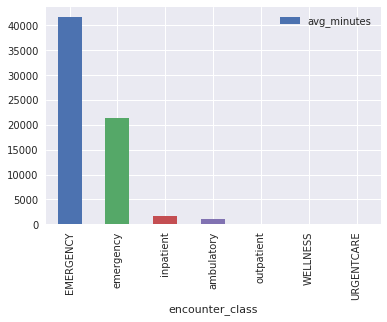

In [53]:
df4.plot(kind='bar', x='encounter_class', y='avg_minutes');